### 1 Setup of WDN & leak-scenario's

In [0]:
import wntr
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from pyspark.sql.functions import col, lit
# Set colormap for network maps
cmap=plt.cm.get_cmap('YlOrRd')

In [0]:
# copy inp file from mount to drive
inp_file_name = "HanoiOptimized.inp"
dbutils.fs.cp("dbfs:/mnt/dlwadlsgen2/waterlink/99QuantumSensorPlacementDEL20/"+inp_file_name, "file:/databricks/driver/"+inp_file_name)
# Create water network model 
wn = wntr.network.WaterNetworkModel(inp_file_name)
wn_dict = wn.to_dict()

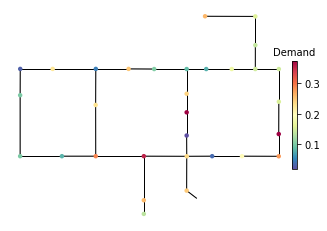

In [0]:
# Show/Vizualize the Water Network Model (Hanoi Optimized)
ax = wntr.graphics.plot_network(wn, node_attribute='base_demand', node_colorbar_label='Demand')

In [0]:
# Define simulation parameters 
start_time    = 2 * 3600 # 2 hours
leak_duration = 4 * 3600 # 4 hours
total_duration = start_time + leak_duration

leak_demand = [x * 3600 / 1000 for x in range(1,50+1)]  # m3/h

minimum_pressure  = 3.52 # 5 psi         ## to be checked = is this correct with our settings ??
required_pressure = 14.06 # 20 psi      ## to be checked = is this correct with our settings ??

min_pipe_diam = 0.1524 # 6 inch
max_pipe_diam = 0.2032 # 8 inch

Tau = 2.5 #pressure-drop threshold 


### 2 Simulate SteadyStateconditions

In [0]:
# Run Steady State simulation
sim = wntr.sim.WNTRSimulator(wn)
result_SteadyState = sim.run_sim()

In [0]:
result_SteadyState.node['demand'].round(decimals=2)

Out[93]:

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,1
0,0.25,0.24,0.04,0.2,0.28,0.38,0.15,0.15,0.15,0.14,0.16,0.26,0.17,0.08,0.09,0.24,0.37,0.02,0.35,0.26,0.13,0.29,0.23,0.05,0.25,0.1,0.08,0.1,0.1,0.03,0.22,-5.54


In [0]:
result_SteadyState.node['pressure'].round(decimals=1)

Out[94]:

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,1
0,97.1,61.7,56.9,51.0,44.8,43.4,41.6,40.2,39.2,37.6,34.2,30.0,35.5,33.7,31.3,33.4,49.9,55.1,50.6,41.3,36.1,44.5,38.9,35.3,31.7,30.8,38.9,30.1,30.4,30.7,33.2,0.0


In [0]:
junct_of_interest = set(wn.node_name_list)
junct_of_interest.remove('1')          # there must be better ways to handle non-junctions, but ok for now

### 3 Simulate LeakScenario's

In [0]:
# Create dictionary to save results
analysis_results = {}

# Simulate for each lead_demand level
for leak_demand_m3h in leak_demand:
  leak_demand_m3s = leak_demand_m3h / 3600 # m3/s
  
  # Create dictionary to save results per leak demand level
  analysis_results_per_leak_demand_level = {}
  
  # Simulate fire flow demand for each hydrant location
  for junct in junct_of_interest:
      wn = wntr.network.WaterNetworkModel(inp_file_name)
      wn.options.hydraulic.demand_model = 'PDD'    
      wn.options.time.duration = total_duration
      wn.options.hydraulic.minimum_pressure = minimum_pressure
      wn.options.hydraulic.required_pressure = required_pressure
  
      # Create leak flow pattern
      leak_flow_pattern = wntr.network.elements.Pattern.binary_pattern(
          'leak_flow',
          start_time=start_time,
          end_time=total_duration,
          step_size=wn.options.time.pattern_timestep,
          duration=wn.options.time.duration
          )
      wn.add_pattern('leak_flow', leak_flow_pattern)
  
      # Apply fire flow pattern to hydrant location
      leak_junct = wn.get_node(junct)
      leak_junct.demand_timeseries_list.append((leak_demand_m3s, leak_flow_pattern, 'Leak flow'))
  
      try:
          # Simulate hydraulics
          sim = wntr.sim.WNTRSimulator(wn) 
          sim_results = sim.run_sim()
   
          HeadLoss = (result_SteadyState.node['pressure'].round(decimals=1).iloc[0] - sim_results.node['pressure'].round(decimals=1).iloc[3]).to_dict()
             
      except Exception as e:
          # Identify failed simulations and the reason
          HeadLoss = None
          print(junct, ' Failed:', e)
  
      finally:
          # Save simulation results
          analysis_results_per_leak_demand_level[junct] = HeadLoss
          
  analysis_results[leak_demand_m3h] = analysis_results_per_leak_demand_level

In [0]:
pdf1 = pd.DataFrame.from_dict(analysis_results, orient='index').stack().to_frame()
pdf1_analysis_results = pd.DataFrame(pdf1[0].values.tolist(), index=pdf1.index).rename_axis(['LeakDemand', 'LeakNode'])
pdf_simulation_results = pd.DataFrame(pdf1_analysis_results.stack().reset_index().rename(columns={"level_2": "SensorLocation", 0: "PressureDrop"}))
sdf_simulation_results=spark.createDataFrame(pdf_simulation_results)

In [0]:
# Store results of pressure-drop simulation for later use
dbutils.fs.rm("dbfs:/mnt/dlwadlsgen2/waterlink/99QuantumSensorPlacementDEL20/simulation_results", True)
sdf_simulation_results.write.format("delta")\
                            .mode("overwrite")\
                            .save("dbfs:/mnt/dlwadlsgen2/waterlink/99QuantumSensorPlacementDEL20/simulation_results")

In [0]:
pdf1_analysis_results

Out[108]:

2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 32 
 1 
 
 
 LeakDemand 
 LeakNode 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 3.6 
 24 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 
 
 18 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 14 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 17 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 30 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.1 
 0.0 
 0.0 
 0.1 
 0.1 
 0.1 
 0.0 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 180.0 
 9 
 0.0 
 0.7 
 0.8 
 1.0 
 1.3 
 1.5 
 1.5 
 1.6 
 1.6 
 1.6 
 1.6 
 1.6 
 1.5 
 1.4 
 1.1 
 0.9 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.8 
 0.9 
 1.0 
 0.7 
 0.8 
 0.8 
 0.8 
 0.8 
 0.0 
 
 
 23 
 0.0 
 0.7 
 0.7 
 0.7 
 0.7 
 0.8 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.8 
 0.9 
 1.0 
 0.9 
 0.7 
 0.7 
 1.1 
 1.1 
 1.1 
 1.4 
 1.4 
 1.4 
 1.3 
 1.2 
 1.4 
 1.4 
 1.4 
 1.4 
 1.4 
 0.0 
 
 
 31 
 0.0 
 0.7 
 0.7 
 0.7 
 0.7 
 0.8 
 0.8 
 0.8 
 0.8 
 0.8 
 0.8 
 0.8 
 0.9 
 1.0 
 1.4 
 1.0 
 0.7 
 0.7 
 1.1 
 1.1 
 1.1 
 1.4 
 1.7 
 2.0 
 1.9 
 1.7 
 1.9 
 3.7 
 3.9 
 4.0 
 2.5 
 0.0 
 
 
 20 
 0.0 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.7 
 0.8 
 0.9 
 0.8 
 0.7 
 0.7 
 1.1 
 1.2 
 1.1 
 1.1 
 1.1 
 1.0 
 1.0 
 1.0 
 1.1 
 1.0 
 1.0 
 1.1 
 1.1 
 0.0 
 
 
 15 
 0.0 
 0.7 
 0.8 
 0.9 
 1.1 
 1.3 
 1.3 
 1.3 
 1.4 
 1.4 
 1.4 
 1.4 
 2.1 
 2.8 
 2.0 
 1.4 
 0.8 
 0.8 
 0.8 
 0.8 
 0.8 
 0.9 
 1.0 
 1.1 
 1.4 
 1.7 
 0.9 
 1.0 
 1.1 
 1.1 
 1.1 
 0.0 
 
 
 
 1550 rows × 32 columns